# VLM for KOMO

In [1]:
import time
import rowan
import torch
import numpy as np
import robotic as ry
import matplotlib.pyplot as plt


import sys
sys.path.append('..')
from utils import grasping_within_komo_definition

In [2]:
torch.cuda.empty_cache()

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device Name: {torch.cuda.get_device_name(device)}" if device.type == "cuda" else "Using cpu")

Device Name: NVIDIA GeForce RTX 3090


## Prepare your scene

In [4]:
C = ry.Config()
C.addFile(ry.raiPath("./scenarios/push_blob.g"))

midpoint = np.array([-0.105, 0.2, 0.745])

C.addFrame("bin") \
    .setPosition(midpoint+np.array([-.22,.2,0])) \
    .setShape(ry.ST.box, size=[0.21, .36, .15]) \
    .setColor([28/255, 18/255, 210/255]) \

def sample_rectangular_arena(width=0.4, height=0.4, z_coord=0.745, center_point=[0, 0]):
    x = center_point[0] + np.random.uniform(-width / 2, width / 2)
    y = center_point[1] + np.random.uniform(-height / 2, height / 2)
    return [x, y, z_coord]

midpoint = sample_rectangular_arena(width=.68, height=.6, center_point=[.19, .32])

base_quat = [-1/np.sqrt(2), 1/np.sqrt(2), 0 ,0 ]
rel_quat = rowan.from_axis_angle([0,1,0], np.random.uniform(0, 2*np.pi))

C.addFrame("blob") \
    .setPosition(midpoint) \
    .setShape(ry.ST.capsule, size=[.08, .07]) \
    .setColor([106/255, 24/255, 79/255]) \
    .setQuaternion(rowan.multiply(base_quat, rel_quat))
C.view()

0

## Define your model (VLM)

In [5]:
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor

model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct",
    torch_dtype="auto",
    device_map=device
)
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct")

/home/eckart/miniconda3/envs/project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46
Loading checkpoint shards: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


## Take a picture of the scene

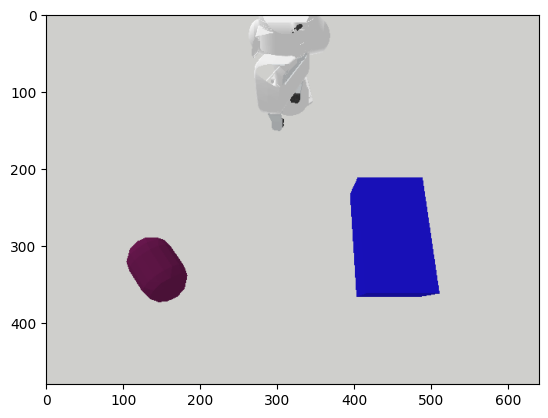

In [6]:
bot = ry.BotOp(C, False)
bot.home(C)
bot.gripperMove(ry._left)

rgb, depth = bot.getImageAndDepth("topCamera")

img_idx = 1
image_path = "../scene_image0.jpg"
plt.imsave(image_path, rgb)
plt.imshow(rgb)

## Prepare initial prompt

In [27]:
from prompting import prompt_qwen

#task_description = "Put the blob in the bin."
task_description = "Push the blob onto the bin."


with open("../prompts/manipulation_modelling/manip_tutorial.txt", 'r') as file:
    manip_tutorial = file.read()

with open("../prompts/manipulation_modelling/problem_definition.txt", 'r') as file:
    problem_definition = file.read()

frame_names = [line for line in C.getFrameNames() if not line.startswith("l_")]
frame_names.append("l_gripper")
frame_names.append("l_palm")

messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "text",
                "text": manip_tutorial,
            },
            {
                "type": "image",
                # "image": image_path,
                "image": "../example_image.jpg",
            },
            {
                "type": "text",
                "text": f"{problem_definition}{task_description}",
            },
            {
                "type": "text",
                "text": f"Here is a list of all available frames: {frame_names}",
            },
        ],
    },
]

In [28]:
print(prompt_qwen(model, processor, device, messages))

```python
M = manip.ManipulationModelling()
M.setup_pick_and_place_waypoints(C, gripper, blob, accumulated_collisions=False)
M.straight_push([1, 2], blob, gripper, table)
M.target_xy_position(2, blob, target_pos)

M1 = M.sub_motion(0)
M1.retractPush([0.0, 0.15], gripper, 0.03)
M1.approachPush([0.85, 1.0], gripper, 0.03)
M1.keep_distance([0.15, 0.85], blob, 'l_palm', 0.02)

M2 = M.sub_motion(1, accumulated_collisions=False)
```
